<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Computer%20Vision/Vegetable_images_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uzazam","key":"7abb2778b77e603b3a87069f481fc6a6"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d moustacheman/vegetable-images

 99% 394M/399M [00:05<00:00, 38.3MB/s]
100% 399M/399M [00:05<00:00, 76.3MB/s]


In [ ]:
#!https://www.kaggle.com/datasets/sanashaikh03/x-ray-images

In [ ]:
#!kaggle datasets download -d adhoppin/blood-cell-detection-datatset

In [ ]:
from zipfile import ZipFile
file_name = "/content/vegetable-images.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
image_size = (512, 512)
batch_size = 12

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Vegetable Images/train",
    #validation_split=0.2,
    #subset="both",
    seed=123456,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Vegetable Images/validation",
    #validation_split=0.2,
    #subset="both",
    seed=123456,
    image_size=image_size,
    batch_size=batch_size,
)

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


Visualize the data

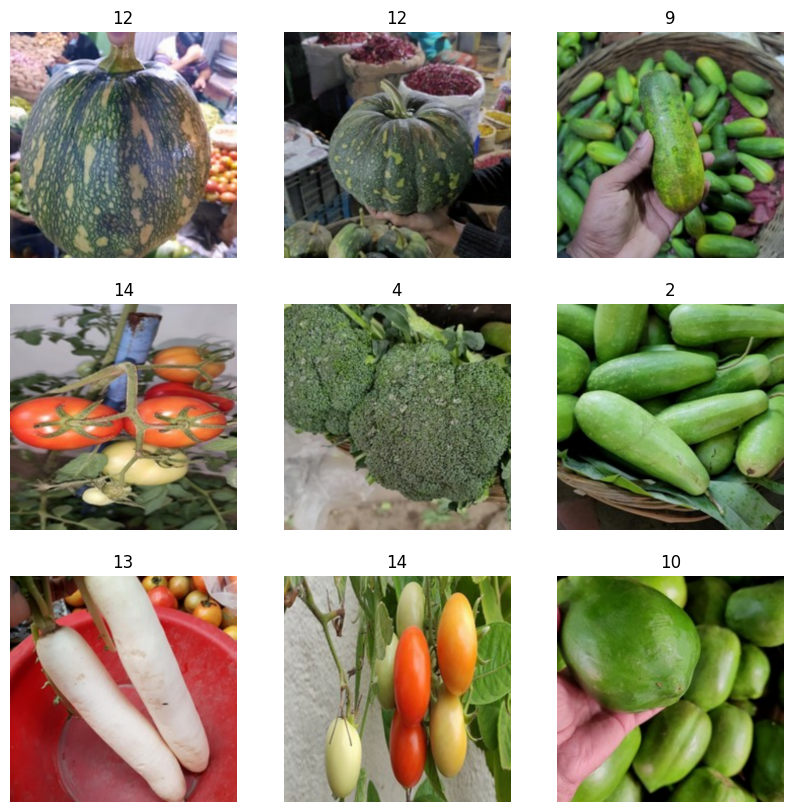

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Using image data augmentation

In [ ]:
AUG = {
    # AUGMENTATION
    'AUGMENTATION_RANDOM_FLIP': 'horizontal',
    'AUGMENTATION_RANDOM_ROTATION':0.5,
    'AUGMENTATION_RANDOM_ZOOM':0.2,
    'AUGMENTATION_RESCALING': 1./255,
    'AUGMENTATION_RANDOM_CONTRAST_FACTOR':0.2,
    'AUGMENTATION_RANDOM_TRANSLATION_HEIGHT_FACTOR':0.1,
    'AUGMENTATION_RANDOM_TRANSLATION_WIDTH_FACTOR':0.1,
    'AUGMENTATION_RANDOM_TRANSLATION_FILL_MODE':'reflect',
    'AUGMENTATION_RANDOM_TRANSLATION_INTERPOLATION':'bilinear',
    'DIRECTORY_SEED': 123456,
}

In [ ]:
AUGMENTATION = keras.Sequential(
  [
    layers.RandomFlip(
        AUG['AUGMENTATION_RANDOM_FLIP']
    ),
    layers.RandomRotation(
        AUG['AUGMENTATION_RANDOM_ROTATION']
    ),
    layers.RandomZoom(
        AUG['AUGMENTATION_RANDOM_ZOOM']
    ),
    layers.RandomContrast(
        factor=AUG['AUGMENTATION_RANDOM_CONTRAST_FACTOR'],
        seed=AUG['DIRECTORY_SEED']
    ),
    layers.RandomTranslation(
        height_factor=AUG['AUGMENTATION_RANDOM_TRANSLATION_HEIGHT_FACTOR'],
        width_factor=AUG['AUGMENTATION_RANDOM_TRANSLATION_WIDTH_FACTOR'],
        fill_mode=AUG['AUGMENTATION_RANDOM_TRANSLATION_FILL_MODE'],
        interpolation=AUG['AUGMENTATION_RANDOM_TRANSLATION_INTERPOLATION'],
        seed=AUG['DIRECTORY_SEED'],
    ),
  ]
)



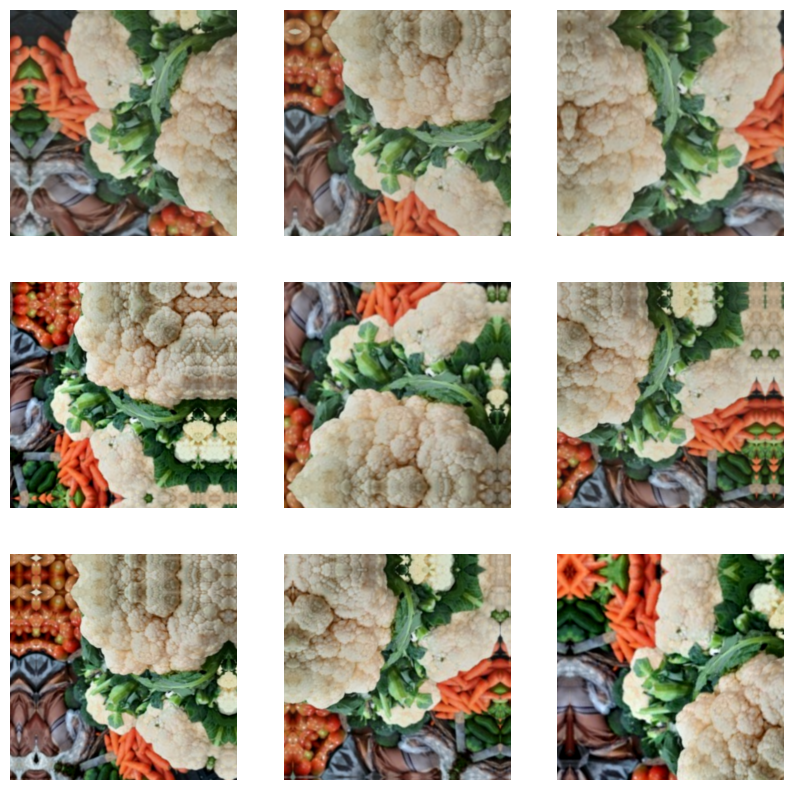

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = AUGMENTATION(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (AUGMENTATION(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
#val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Apply `data_augmentation` to the training images.
val_ds = train_ds.map(
    lambda img, label: (AUGMENTATION(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
#train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

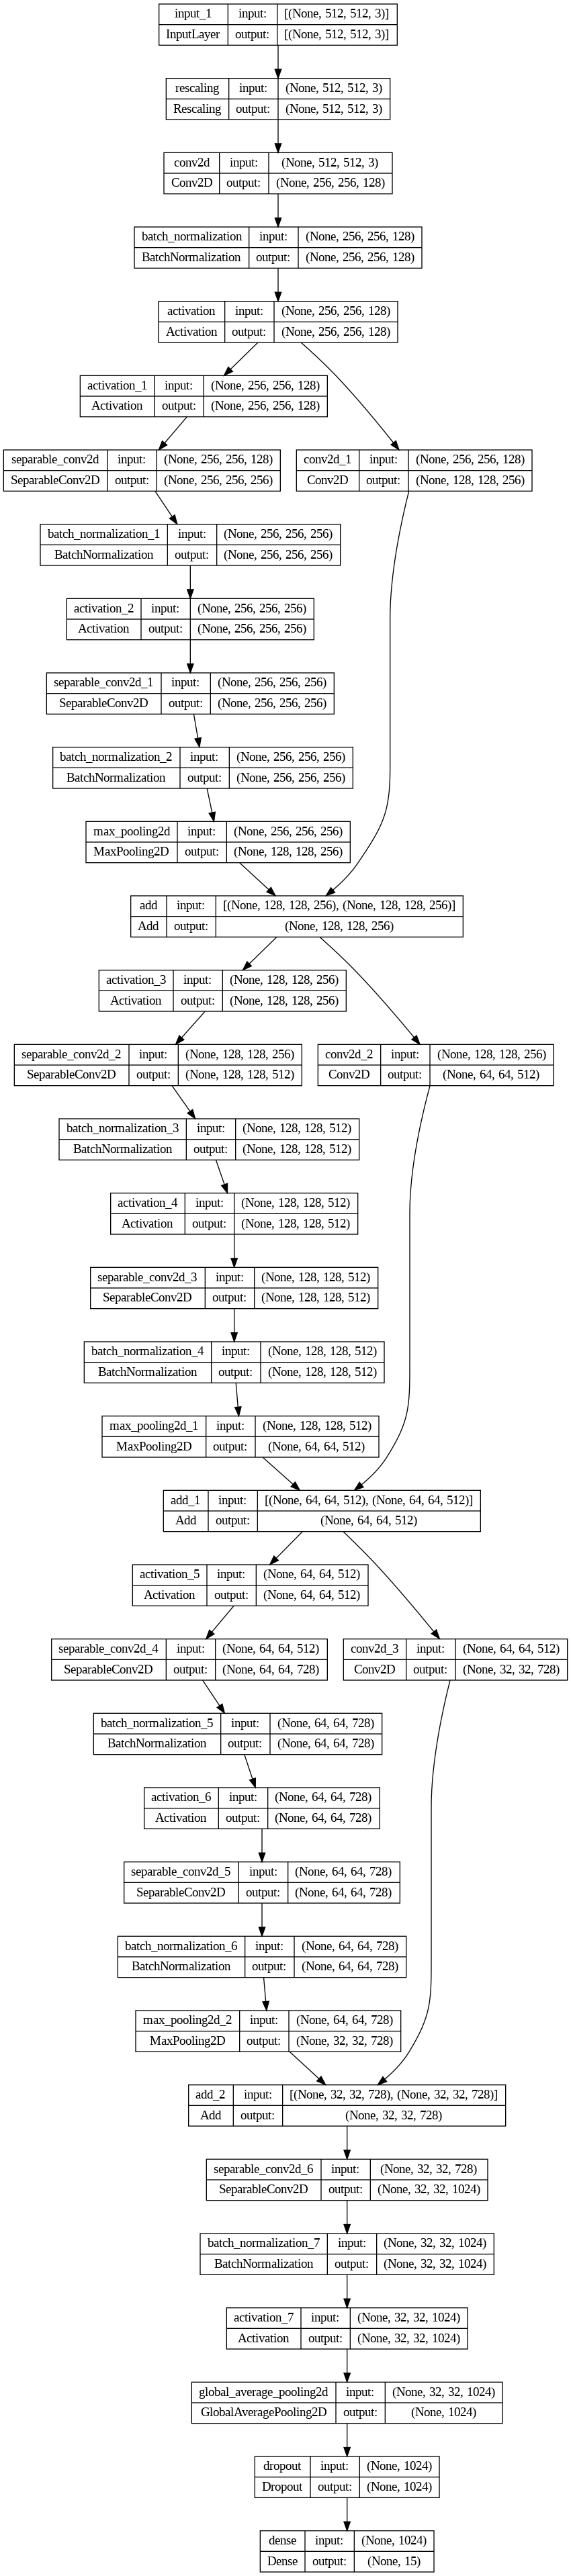

In [ ]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)




model = make_model(input_shape=image_size + (3,), num_classes=15)
keras.utils.plot_model(model, show_shapes=True)





Train the model

In [ ]:
epochs = 7

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/7
539/753 [====================>.........] - ETA: 2:43:28 - loss: 1.6435 - accuracy: 0.4773